In [1]:
# SIMPLE LINEAR REGRESSION

In [2]:
# GENERAL INCLUSIONS
import numpy as np
import glob,os
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import pickle

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline

# FOR DATES AND TIMES #
import time
import datetime
from dateutil import tz
from datetime import timedelta
import arrow

In [3]:
# CONVERT UNIX (utc) TIMESTAMP TO YYYY-mm-dd HH:MM:SS (EASTERN)
def conv_unixts_to_east_hms(ts):
    east=arrow.Arrow.fromtimestamp(ts).to('US/Eastern')
    return east.format('YYYY-MM-DD HH:mm:ss')

def get_hour(dt_str):
    return dt_str[11:13]

def get_month_num(dt_str):
    return dt_str[5:7]


# RETURNS DAY OF WEEK 
# M-0, Tu-1, W-2, Th-3 F-4 Sa-6 Su-7
# TAKES YYYY-MM-DD HH:MM:SS RETURNS Day (IN WHATEVER TIMEZONE)
def get_day_of_week(dt):
    dtt = arrow.get(dt)
    return dtt.weekday()

# TAKES UNIX TS RETURNS Day (IN EASTERN/BOSTON)
def get_day_of_week_east_unix(ts):
    east=conv_unixts_to_east_hms(ts)
    return get_day_of_week(east)
    
# TAKES UNIX TS RETURNS Day (IN UTC)
def get_day_of_week_utc_unix(ts):
    utc=conv_unixts_to_utc_hms(ts)
    return get_day_of_week(utc)
    


In [4]:
### ML SPECIFIC FUNCTIONS
### FOR FEATURE ENGINEERING
# ONE HOT ENCODE EVENT -- 1--event, 0--no event
def bin_event(x):
    x=int(x)
    if(x!=0):
        return 1
    else:
        return 0

# YES OR NO 
def bin_weather(x):
    x=float(x)
    if(x>0):
        return 1
    else:
        return 0
    
# BIN PRECIPITATION TYPE
def bin_ptype(x):
    if(x==1): # None
        return 0
    else: # rain, snow or sleet
        return 0
    
# BIN IN d_bin SECONDS
d_bin=30
def bin_delay(x):
    x=float(x)
    if(x<=0):
        return 0
    else:
        return int(x/d_bin)
    
#BIN IN t_bin DEGREES
t_bin=10
def bin_temp(x):
    x=float(x)
    if(x<=0):
        return 0
    else:
        return int(x/t_bin)
    
        
# PEAK HOUR BIN
def bin_peak(x):
    x=float(x)
    if(6<=x<=10 or 4<=x<=7):
        return 1
    else:
        return 0
           
# WEEKDAY BIN
def bin_weekday(x):
    x=float(x)
    if(x<5):
        return 1 # WEEKDAY
    else:
        return 0 # WEEKEND
    
# SEASON
def bin_season(x):
    x=float(x)
    if(x in {1,2,12}):
        return 0 # WINTER
    elif(x in {3,4,5}):
        return 1 # SPRING
    elif(x in {9,10,11}):
        return 2 # FALL
    elif(x in {6,7,8}):
        return 3 # SUMMER
    else:
        print("NOT A VALID MONTH")
        return -1 # WRONG

In [11]:
# another self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Relative Absolute Error (RAE)
def rae(y_true, y_pred):
    return 'RAE', np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(np.mean(y_true) - y_true)), False


In [5]:
MBTdelay_df=[]
ds_files=glob.glob("DS/DS_*.csv")
for ds_f in ds_files:
#     print(ds_f)
    station_name,station_id=ds_f.replace("DS/DS_","").replace(".csv","").split("_")
    df_temp=pd.read_csv(ds_f)

    MBTdelay_df.append([station_name,station_id,df_temp])
    
    # ENCODE PRECIP TYPE AS NUMBER
MBTdelay_df=np.array(MBTdelay_df)
MBTdelay_df[0][2].columns

Index(['Unnamed: 0', 'U_DATETIME', 'HEAD_GAP', 'HDW_T', 'BNCH_HDW_T', 'TEMP',
       'PRECIP_INT', 'PRECIP_PRO', 'PRECIP_ACC', 'PRECIP_TYP', 'u_datetime',
       'event', 'period', 'DN', 'DATETIME', 'HOUR_BIN', 'MONTH_BIN', 'DOW',
       'PRECIP_TYP_ENC'],
      dtype='object')

In [6]:
# MBTdelay_df[0][2]['MONTH_BIN'].unique()

In [17]:
# RESULTS OF THE FUNCTION BELOW #
f_combo_1=[0,0,1,0,1,0,1,0,0]
f_combo_2=[0,1,1,0,1,0,1,0,0] # <-- THIS IS THE BEST COMBO

# FEATURE ENGINEER DATA AND PERFORM TRAIN-TEST SPLIT
def feature_engineer_and_split(loc_df,EVENT_FLAG,SNOW_YN_FLAG,RAIN_YN_FLAG,
          WEEKDAY_FLAG,PRECIP_TYP_FLAG,PEAK_FLAG,DELAY_FLAG,SEASON_FLAG,TEMP_FLAG,split_perc,shuffle_flag):
    
#     print(np.mean(test_df['HEAD_GAP']))
    fe_df=loc_df[np.isfinite(loc_df['TEMP'])].copy()

    if(EVENT_FLAG==1):
        fe_df['event']=fe_df['event'].apply(lambda x: bin_weather(x))

    if(SNOW_YN_FLAG==1):
        fe_df['PRECIP_ACC']=fe_df['PRECIP_ACC'].apply(lambda x: bin_weather(x))

    if(RAIN_YN_FLAG==1):
        fe_df['PRECIP_INT']=fe_df['PRECIP_INT'].apply(lambda x: bin_weather(x))

    if(WEEKDAY_FLAG==1):
        fe_df['DOW']=fe_df['DOW'].apply(lambda x: bin_weekday(x))
        
    if(PRECIP_TYP_FLAG==1):
        fe_df['PRECIP_TYP_ENC']=fe_df['PRECIP_TYP_ENC'].apply(lambda x: bin_ptype(x))

    if(PEAK_FLAG==1):
        fe_df['HOUR_BIN']=fe_df['HOUR_BIN'].apply(lambda x: bin_peak(x))

    if(DELAY_FLAG==1):
        fe_df['HEAD_GAP']=fe_df['HEAD_GAP'].apply(lambda x: bin_delay(x))

    if(SEASON_FLAG==1):
        fe_df['MONTH_BIN']=fe_df['MONTH_BIN'].apply(lambda x: bin_season(x))
        
    if(TEMP_FLAG==1):
        fe_df['TEMP']=fe_df['TEMP'].apply(lambda x: bin_temp(x))


    all_x=np.transpose(np.array([fe_df['HOUR_BIN'], fe_df['DOW'], fe_df['MONTH_BIN'],
                                fe_df['event'],fe_df['PRECIP_TYP_ENC'],
                                fe_df['PRECIP_INT'], fe_df['PRECIP_ACC'], 
                                fe_df['PRECIP_PRO'], fe_df['TEMP']],dtype=np.float32))

    all_y=np.array([fe_df['HEAD_GAP']],dtype=np.float32)[0]


    X_train, X_test, y_train, y_test = train_test_split(all_x, all_y, test_size=split_perc, random_state=0,shuffle=shuffle_flag)
    
    return X_train, X_test, y_train, y_test 


In [18]:
## THIS IS JUST FOR TESTING ##

# TEST STATION NUMBER # 
station_num_id=3

test_size=0.2

# LOCAL LOAD DATAFRAME 
station_name=MBTdelay_df[station_num_id][0]
station_id=MBTdelay_df[station_num_id][1]
test_df=MBTdelay_df[station_num_id][2].copy()
test_df = test_df[np.isfinite(test_df['HEAD_GAP'])]

X_train, X_test, y_train, y_test=feature_engineer_and_split(test_df, 0,1,1,0,1,0,1,0,0,test_size,False)
# X_train, X_test, y_train, y_test=feature_engineer_and_split(df_loc,0,1,1,0,1,0,1,0,0,0.2) # FEATURE ENGINEERED
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

print('Saving model...')
# save model to file
pickle.dump(regr, open('NEW_LR_MODEL/'+station_name+'_'+station_id+'.pk', 'wb'))
    

print('Starting predicting...')

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
print('The rae of prediction is:', rae(y_test, y_pred)[1])
print('Variance score: ',r2_score(y_test,y_pred))


Saving model...
Starting predicting...
The rmse of prediction is: 8.703036021902653
The rae of prediction is: 0.87529707
Variance score:  -0.10892979856316254


In [19]:
print(y_test,y_pred,y_pred-y_test)

[1. 6. 4. ... 3. 1. 4.] [2.0542583 1.9745562 2.14776   ... 1.6477038 1.5886531 1.5322828] [ 1.0542583 -4.025444  -1.8522401 ... -1.3522962  0.5886531 -2.4677172]


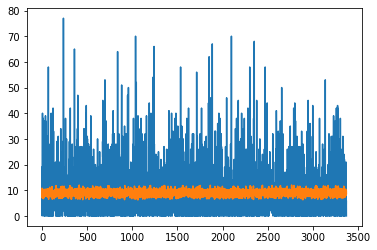

In [15]:
plt.plot(np.arange(len(y_test)),y_test)
plt.plot(np.arange(len(y_pred)),y_pred)

In [14]:
# BUFFERS FOR ANALYTICS
data_metrics=[]
model_outcomes=[]

# TRAIN-TEST SPLIT
test_size=0.2

# PARAMETERS DETERMINED FROM CV SCAN 
params_prod = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 8,
    'learning_rate': 0.12,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# RUN MODEL FOR ALL STATIOS AND SAVE TO FILE #
for station_num_id in range(len(MBTdelay_df)):
    
    # LOAD DATAFRAME 
    station_name=MBTdelay_df[station_num_id][0]
    station_id=MBTdelay_df[station_num_id][1]
    test_df=MBTdelay_df[station_num_id][2].copy()

    # SIMPLE STATS FOR DATA FOR A STATION
    gap_mode=stats.mode(test_df['HEAD_GAP'].values)
    gap_mean=np.mean(test_df['HEAD_GAP'])
    gap_mean_unc=np.std(test_df['HEAD_GAP'])/np.sqrt(len(test_df['HEAD_GAP']))
    
    # SAVE METRICS TO ARRAY 
    data_metrics.append([station_name,station_id,
                    gap_mode,
                    gap_mean,
                    gap_mean_unc
                    ])
    
    # GENERATE TEST-TRAIN SPLIT -- USES FEATURE ENGINEERING DETERMINED PREVIOUSLY #
    X_train, X_test, y_train, y_test=feature_engineer_and_split(test_df, 0,1,1,0,1,0,1,0,0, test_size)
    
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    print('Saving model...')
    # save model to file
    pickle.dump(regr, open('NEW_LR_MODEL/'+station_name+'_'+station_id+'.pk', 'wb'))

    print('Starting predicting...')

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # EVALUATE METRICS
    mae=metrics.mean_absolute_error(y_test, y_pred)
    mse=metrics.mean_squared_error(y_test, y_pred)
    rmse=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2=r2_score(y_test,y_pred)
    
    # SAVE MODEL METRICS
    model_outcomes.append([station_name,station_id,mae,mse,rmse,r2])

model_outcomes=np.array(model_outcomes)


Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting predicting...
Saving model...
Starting 

In [60]:
station_num_id=3

results=[RunRF(station_num_id,EVENT_FLAG,SNOW_YN_FLAG,
          RAIN_YN_FLAG,WEEKDAY_FLAG,PRECIP_TYP_FLAG,PEAK_FLAG,DELAY_FLAG,SEASON_FLAG) 
         for EVENT_FLAG in {0,1}
         for SNOW_YN_FLAG in {0,1}
         for RAIN_YN_FLAG in {0,1}
         for WEEKDAY_FLAG in {0,1}
         for PRECIP_TYP_FLAG in {0,1}
         for PEAK_FLAG in {0,1}
         for DELAY_FLAG in {0,1}
         for SEASON_FLAG in {0,1}
        ]


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.16288971331387
Mean Squared Error: 34032.9884748534
Root Mean Squared Error: 184.4803200204656
Variance test: 0.06827464249538695


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.49300207508955
Mean Squared Error: 34216.57531704425
Root Mean Squared Error: 184.97722918522769
Variance test: 0.06324856268756185


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.17244915961244
Mean Squared Error: 34063.06559268157
Root Mean Squared Error: 184.56182051735826
Variance test: 0.06745121750049232


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.53943045515535
Mean Squared Error: 34241.83860253966
Root Mean Squared Error: 185.04550414030507
Variance test: 0.06255692657904466


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.48400241501132
Mean Squared Error: 35266.56900308763
Root Mean Squared Error: 187.79395358500665
Variance test: 0.03450275497722177


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.73431249896167
Mean Squared Error: 35389.18398677571
Root Mean Squared Error: 188.1201317955516
Variance test: 0.031145909321524723


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.49826053068533
Mean Squared Error: 35292.315219868724
Root Mean Squared Error: 187.86249018861835
Variance test: 0.03379789759884355


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.75418193215687
Mean Squared Error: 35400.99145564423
Root Mean Squared Error: 188.15151196746794
Variance test: 0.030822654778043246


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.10725158345068
Mean Squared Error: 34018.78437617874
Root Mean Squared Error: 184.44181840401254
Variance test: 0.06866350987109393


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.46555743483381
Mean Squared Error: 34195.44411692263
Root Mean Squared Error: 184.9201019817008
Variance test: 0.06382707418097255


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.05104621302212
Mean Squared Error: 34008.31350702199
Root Mean Squared Error: 184.41343092904592
Variance test: 0.0689501721580591


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.4496192571015
Mean Squared Error: 34194.41924587677
Root Mean Squared Error: 184.91733084239772
Variance test: 0.0638551322030384


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.48009891832635
Mean Squared Error: 35266.4566263944
Root Mean Squared Error: 187.79365438266117
Variance test: 0.03450583152792641


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.71267088441101
Mean Squared Error: 35389.47782143746
Root Mean Squared Error: 188.12091277005186
Variance test: 0.03113786497345128


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.46285659679602
Mean Squared Error: 35265.38822373669
Root Mean Squared Error: 187.790809742481
Variance test: 0.03453508132034311


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.7430732757779
Mean Squared Error: 35397.12900417545
Root Mean Squared Error: 188.14124748224523
Variance test: 0.030928397592202783


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.32580751634161
Mean Squared Error: 34108.8682751342
Root Mean Squared Error: 184.6858637663809
Variance test: 0.06619727176738743


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.74543499962346
Mean Squared Error: 34348.43257130686
Root Mean Squared Error: 185.33330130148457
Variance test: 0.059638690241062275


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.3184216960243
Mean Squared Error: 34117.77388721815
Root Mean Squared Error: 184.7099723545487
Variance test: 0.06595346171794536


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.73129660327572
Mean Squared Error: 34354.825860234094
Root Mean Squared Error: 185.35054858358012
Variance test: 0.05946366037509088


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.43125071237564
Mean Squared Error: 35280.598997632995
Root Mean Squared Error: 187.83130462634017
Variance test: 0.0341186540719125


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.70156505406624
Mean Squared Error: 35420.38364766348
Root Mean Squared Error: 188.20303835927697
Variance test: 0.03029175232569814


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.38968787171599
Mean Squared Error: 35267.151744873045
Root Mean Squared Error: 187.79550512425223
Variance test: 0.03448680118289793


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.68670246800987
Mean Squared Error: 35411.40050455091
Root Mean Squared Error: 188.17917128245332
Variance test: 0.030537684951751687


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.27318865292128
Mean Squared Error: 34105.40536096949
Root Mean Squared Error: 184.67648838162776
Variance test: 0.06629207639909074


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.69974504057147
Mean Squared Error: 34294.72469187552
Root Mean Squared Error: 185.18834923362624
Variance test: 0.0611090575348705


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.32648445501391
Mean Squared Error: 34118.49099939805
Root Mean Squared Error: 184.71191352860282
Variance test: 0.06593382924862301


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.75541985060903
Mean Squared Error: 34332.17317848313
Root Mean Squared Error: 185.2894308331782
Variance test: 0.0600838256602656


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.41335132363851
Mean Squared Error: 35231.82691909456
Root Mean Squared Error: 187.70143025319376
Variance test: 0.035453893330905095


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.69883155714362
Mean Squared Error: 35421.74140069166
Root Mean Squared Error: 188.20664547430746
Variance test: 0.03025458095220801


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.4053780745691
Mean Squared Error: 35266.24098002893
Root Mean Squared Error: 187.7930802240299
Variance test: 0.034511735305289615


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.72066381886118
Mean Squared Error: 35417.31308093525
Root Mean Squared Error: 188.19488059172932
Variance test: 0.030375815612844193


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.0617400060168
Mean Squared Error: 33973.59111039726
Root Mean Squared Error: 184.31926407838455
Variance test: 0.06990077152821106


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.41368925203658
Mean Squared Error: 34182.88589331802
Root Mean Squared Error: 184.88614305382117
Variance test: 0.06417088223022072


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.06092545426017
Mean Squared Error: 34003.65876260354
Root Mean Squared Error: 184.40081009204798
Variance test: 0.06907760567482402


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.45915350325129
Mean Squared Error: 34218.01024669995
Root Mean Squared Error: 184.98110781023004
Variance test: 0.06320927843994284


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.51747500140159
Mean Squared Error: 35194.053790738835
Root Mean Squared Error: 187.6007830227231
Variance test: 0.03648801296301751


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.89483497725838
Mean Squared Error: 35421.9805786916
Root Mean Squared Error: 188.2072808865045
Variance test: 0.030248032946361803


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.59682945261736
Mean Squared Error: 35246.52548789712
Root Mean Squared Error: 187.74058029072222
Variance test: 0.03505148878501907


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.83553132853525
Mean Squared Error: 35415.97358312952
Root Mean Squared Error: 188.19132175296903
Variance test: 0.030412487210839223


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 112.98941791709073
Mean Squared Error: 33968.847020196925
Root Mean Squared Error: 184.3063944094098
Variance test: 0.07003065107555706


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.37914997723608
Mean Squared Error: 34145.07855075961
Root Mean Squared Error: 184.78386983381316
Variance test: 0.06520593854881473


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 112.97445434731397
Mean Squared Error: 33956.271309011965
Root Mean Squared Error: 184.27227493307822
Variance test: 0.07037493788446703


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.44225742259492
Mean Squared Error: 34174.93230965337
Root Mean Squared Error: 184.86463239260604
Variance test: 0.0643886284792422


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.48497960641096
Mean Squared Error: 35214.43423630826
Root Mean Squared Error: 187.65509381924133
Variance test: 0.03593005497033919


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.84698487848506
Mean Squared Error: 35397.80493799391
Root Mean Squared Error: 188.14304382037065
Variance test: 0.03090989246800202


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.52965526992072
Mean Squared Error: 35223.53140946641
Root Mean Squared Error: 187.67933133263878
Variance test: 0.03568100052954781


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.88192842357655
Mean Squared Error: 35437.31254823212
Root Mean Squared Error: 188.2480080856956
Variance test: 0.029828287709708468


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.26258945911394
Mean Squared Error: 34076.774875966934
Root Mean Squared Error: 184.59895686586893
Variance test: 0.06707589674722869


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.72401176142894
Mean Squared Error: 34326.00867259957
Root Mean Squared Error: 185.2727952846817
Variance test: 0.060252592104400815


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.25010841999412
Mean Squared Error: 34033.662085379816
Root Mean Squared Error: 184.48214570895422
Variance test: 0.06825620097624141


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.68887435984847
Mean Squared Error: 34308.450216213954
Root Mean Squared Error: 185.22540380901847
Variance test: 0.06073329214827761


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.40588841296051
Mean Squared Error: 35210.402126977446
Root Mean Squared Error: 187.64435010673103
Variance test: 0.03604044252888472


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.95118643067336
Mean Squared Error: 35467.94039113006
Root Mean Squared Error: 188.32934022910518
Variance test: 0.02898978544609543


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.39008337260084
Mean Squared Error: 35217.062069918364
Root Mean Squared Error: 187.66209545328635
Variance test: 0.03585811244282233


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.96997470914778
Mean Squared Error: 35469.03128172175
Root Mean Squared Error: 188.33223643795492
Variance test: 0.028959919998713723


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.19590520582327
Mean Squared Error: 34023.643115278064
Root Mean Squared Error: 184.45498940196242
Variance test: 0.06853049156658364


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.6785981002365
Mean Squared Error: 34288.34395334007
Root Mean Squared Error: 185.17112073252693
Variance test: 0.06128374380720547


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.22171577783253
Mean Squared Error: 34022.45798219465
Root Mean Squared Error: 184.4517768474857
Variance test: 0.06856293710238048


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.70047115553659
Mean Squared Error: 34285.86401995799
Root Mean Squared Error: 185.16442428273848
Variance test: 0.06135163725178827


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.3157939634882
Mean Squared Error: 35163.54748454657
Root Mean Squared Error: 187.51945894905566
Variance test: 0.03732318790112599


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.95641234647273
Mean Squared Error: 35475.59591945336
Root Mean Squared Error: 188.34966397488836
Variance test: 0.028780199095217784


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.34385767281803
Mean Squared Error: 35170.844376628294
Root Mean Squared Error: 187.53891429948158
Variance test: 0.03712341997923041


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.95573256169234
Mean Squared Error: 35470.73772394475
Root Mean Squared Error: 188.33676678743518
Variance test: 0.02891320251777707


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.12543534698845
Mean Squared Error: 34011.483341585794
Root Mean Squared Error: 184.4220250989176
Variance test: 0.06886339120303431


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.51098233643694
Mean Squared Error: 34206.28599945819
Root Mean Squared Error: 184.94941470428662
Variance test: 0.06353025461460005


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.12919759570424
Mean Squared Error: 34009.532887046174
Root Mean Squared Error: 184.41673700357615
Variance test: 0.06891678903950593


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.53706722847589
Mean Squared Error: 34212.907201620204
Root Mean Squared Error: 184.96731387361444
Variance test: 0.06334898513965881


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.45591588958379
Mean Squared Error: 35206.23232945842
Root Mean Squared Error: 187.63323887163068
Variance test: 0.03615459959408085


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.73662020176829
Mean Squared Error: 35351.69523129621
Root Mean Squared Error: 188.02046492681643
Variance test: 0.03217224364204274


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.47980845049608
Mean Squared Error: 35235.50830266029
Root Mean Squared Error: 187.71123648482072
Variance test: 0.03535310763524324


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.75880541866789
Mean Squared Error: 35347.52710404107
Root Mean Squared Error: 188.00938036183481
Variance test: 0.03228635498021637


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.10380657391401
Mean Squared Error: 33973.7871873082
Root Mean Squared Error: 184.3197959724028
Variance test: 0.06989540350623813


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.51715516093573
Mean Squared Error: 34191.00974890356
Root Mean Squared Error: 184.90811163630318
Variance test: 0.06394847442564766


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.0907503168703
Mean Squared Error: 33965.292946282214
Root Mean Squared Error: 184.29675240297158
Variance test: 0.07012795139907191


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.50948201333898
Mean Squared Error: 34177.22199342568
Root Mean Squared Error: 184.87082515482447
Variance test: 0.0643259435218837


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.4699140722212
Mean Squared Error: 35204.816362942554
Root Mean Squared Error: 187.6294656042663
Variance test: 0.03619336468546219


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.73162670007264
Mean Squared Error: 35353.60440270075
Root Mean Squared Error: 188.02554188912939
Variance test: 0.03211997601909378


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.48835661353965
Mean Squared Error: 35213.5820903924
Root Mean Squared Error: 187.65282329448817
Variance test: 0.03595338427504258


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.75243808001592
Mean Squared Error: 35347.9105233663
Root Mean Squared Error: 188.01040004044006
Variance test: 0.032275858061671214


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.30009149326125
Mean Squared Error: 34060.877521093986
Root Mean Squared Error: 184.55589267507548
Variance test: 0.067511120608434


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.73504940272
Mean Squared Error: 34324.937046395746
Root Mean Squared Error: 185.2699032395595
Variance test: 0.06028193014824057


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.27575537250249
Mean Squared Error: 34056.14669147803
Root Mean Squared Error: 184.54307543627323
Variance test: 0.06764063711911228


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.71273616459835
Mean Squared Error: 34313.49727792438
Root Mean Squared Error: 185.2390274157268
Variance test: 0.06059511811222529


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.34277637600532
Mean Squared Error: 35188.15041434062
Root Mean Squared Error: 187.58504848292313
Variance test: 0.03664963043276093


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.73022285156269
Mean Squared Error: 35395.27060631468
Root Mean Squared Error: 188.13630858054668
Variance test: 0.030979275181530208


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.35559194800182
Mean Squared Error: 35203.684028986376
Root Mean Squared Error: 187.62644810630076
Variance test: 0.03622436473298707


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.70536446097351
Mean Squared Error: 35378.761868721
Root Mean Squared Error: 188.09242905742113
Variance test: 0.03143123694350691


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.24500944179947
Mean Squared Error: 34043.87605424453
Root Mean Squared Error: 184.50982644359223
Variance test: 0.06797657188051709


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.73039602805342
Mean Squared Error: 34256.41201328689
Root Mean Squared Error: 185.08487786225783
Variance test: 0.06215794850080281


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.27458042928268
Mean Squared Error: 34050.984183874156
Root Mean Squared Error: 184.52908763626985
Variance test: 0.06778197173174538


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.7010143418806
Mean Squared Error: 34289.34199757112
Root Mean Squared Error: 185.17381563701474
Variance test: 0.06125642022618427


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.31732707050507
Mean Squared Error: 35180.87906743365
Root Mean Squared Error: 187.56566601442185
Variance test: 0.03684869900123078


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.74027070642903
Mean Squared Error: 35383.54738159313
Root Mean Squared Error: 188.10514980083116
Variance test: 0.03130022336252414


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.33665012936677
Mean Squared Error: 35184.34291996621
Root Mean Squared Error: 187.57489949341894
Variance test: 0.036753868679713975


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.70834607982289
Mean Squared Error: 35368.4932196569
Root Mean Squared Error: 188.06513025985677
Variance test: 0.03171236302584923


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.11422257735099
Mean Squared Error: 33946.684739730335
Root Mean Squared Error: 184.2462611282257
Variance test: 0.0706373905837876


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.53747291712797
Mean Squared Error: 34207.65116845529
Root Mean Squared Error: 184.95310532255274
Variance test: 0.06349288021320643


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.0905355683545
Mean Squared Error: 33939.06696460981
Root Mean Squared Error: 184.22558716044253
Variance test: 0.07084594336053851


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.49094587566871
Mean Squared Error: 34197.94320059016
Root Mean Squared Error: 184.9268590567367
Variance test: 0.06375865645664336


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.62765771816052
Mean Squared Error: 35208.76552036125
Root Mean Squared Error: 187.63998912907996
Variance test: 0.03608524811172964


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.9736239058007
Mean Squared Error: 35406.61330522244
Root Mean Squared Error: 188.16645106187883
Variance test: 0.03066874470305936


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.61048416058588
Mean Squared Error: 35201.38337996007
Root Mean Squared Error: 187.62031707669632
Variance test: 0.036287349887467735


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.98785672991029
Mean Squared Error: 35401.62422716294
Root Mean Squared Error: 188.15319350774502
Variance test: 0.030805331313489837


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.09269398792961
Mean Squared Error: 33932.05378454928
Root Mean Squared Error: 184.2065519587978
Variance test: 0.07103794406315


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.52231883371715
Mean Squared Error: 34195.966002135014
Root Mean Squared Error: 184.92151308632268
Variance test: 0.06381278646461619


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.04218363675515
Mean Squared Error: 33914.39865399079
Root Mean Squared Error: 184.1586236210262
Variance test: 0.07152129076787883


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.50007031641906
Mean Squared Error: 34195.363599710494
Root Mean Squared Error: 184.91988427346178
Variance test: 0.06382927851070141


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.55821126560025
Mean Squared Error: 35158.22625172883
Root Mean Squared Error: 187.5052699305511
Variance test: 0.037468867953676765


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.06820045230283
Mean Squared Error: 35431.553328942304
Root Mean Squared Error: 188.23271057109682
Variance test: 0.029985958572369187


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.64220956503736
Mean Squared Error: 35182.184681495215
Root Mean Squared Error: 187.56914640072128
Variance test: 0.0368129550427132


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.04370931226079
Mean Squared Error: 35426.024709536665
Root Mean Squared Error: 188.21802440132205
Variance test: 0.0301373162733255


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.35121022506085
Mean Squared Error: 34049.693216019834
Root Mean Squared Error: 184.5255895967273
Variance test: 0.06781731471922592


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.84300874967123
Mean Squared Error: 34347.573280378005
Root Mean Squared Error: 185.33098305566182
Variance test: 0.059662215155674936


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.31993742093067
Mean Squared Error: 34047.494546072056
Root Mean Squared Error: 184.51963187171185
Variance test: 0.06787750797979264


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.80919810474573
Mean Squared Error: 34337.13145911535
Root Mean Squared Error: 185.3028101759802
Variance test: 0.059948082194831165


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.49658044494016
Mean Squared Error: 35189.24942467368
Root Mean Squared Error: 187.58797782553572
Variance test: 0.03661954269020984


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.141422220134
Mean Squared Error: 35480.906923254
Root Mean Squared Error: 188.36376223481523
Variance test: 0.028634799083740003


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.47876808834789
Mean Squared Error: 35195.28527369026
Root Mean Squared Error: 187.60406518434044
Variance test: 0.036454298501120586


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.1289126321376
Mean Squared Error: 35486.57265509439
Root Mean Squared Error: 188.37880097052957
Variance test: 0.028479687638607643


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.30772584769957
Mean Squared Error: 34014.83280245081
Root Mean Squared Error: 184.4311058429429
Variance test: 0.0687716925964248


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.88521430686461
Mean Squared Error: 34337.496027415335
Root Mean Squared Error: 185.3037938829514
Variance test: 0.059938101363148144


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.37814511757792
Mean Squared Error: 34039.57837173544
Root Mean Squared Error: 184.49817986022367
Variance test: 0.06809423006898863


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.84021934008673
Mean Squared Error: 34346.36523869488
Root Mean Squared Error: 185.32772388041374
Variance test: 0.05969528786305478


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.39305076315114
Mean Squared Error: 35139.84155086917
Root Mean Squared Error: 187.45623902892422
Variance test: 0.0379721881952636


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.12850099299772
Mean Squared Error: 35480.34813618049
Root Mean Squared Error: 188.36227896312067
Variance test: 0.02865009706693722


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.38307479182569
Mean Squared Error: 35126.912607864724
Root Mean Squared Error: 187.4217506264007
Variance test: 0.0383261454756203


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.13007341502974
Mean Squared Error: 35477.916672860454
Root Mean Squared Error: 188.35582463215852
Variance test: 0.028716663540604204


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.16736118204562
Mean Squared Error: 34064.782507601005
Root Mean Squared Error: 184.56647178618604
Variance test: 0.06740421330724311


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.48369255077287
Mean Squared Error: 34225.07693600704
Root Mean Squared Error: 185.0002079350373
Variance test: 0.06301581280803448


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.1529337932199
Mean Squared Error: 34019.078834235486
Root Mean Squared Error: 184.4426166433221
Variance test: 0.06865544845625826


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.48170365488015
Mean Squared Error: 34220.0439152673
Root Mean Squared Error: 184.98660469144056
Variance test: 0.06315360244268631


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.55035856087697
Mean Squared Error: 35278.097091404
Root Mean Squared Error: 187.82464452622824
Variance test: 0.03418714906985765


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.74444470450841
Mean Squared Error: 35399.36846045396
Root Mean Squared Error: 188.14719891737417
Variance test: 0.03086708771918789


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.53319630442158
Mean Squared Error: 35276.42801022302
Root Mean Squared Error: 187.82020128362927
Variance test: 0.03423284371290081


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.70729852517823
Mean Squared Error: 35365.4898724229
Root Mean Squared Error: 188.057145230972
Variance test: 0.03179458603654306


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.08588193308488
Mean Squared Error: 34028.677094942606
Root Mean Squared Error: 184.4686344475467
Variance test: 0.06839267567932816


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.46927902948423
Mean Squared Error: 34203.16973523227
Root Mean Squared Error: 184.9409898730735
Variance test: 0.06361556896782272


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.12036628166513
Mean Squared Error: 34010.03898134225
Root Mean Squared Error: 184.41810914696597
Variance test: 0.06890293363302902


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.46388010635087
Mean Squared Error: 34190.22765662771
Root Mean Squared Error: 184.90599681088688
Variance test: 0.06396988586313745


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.48239599958302
Mean Squared Error: 35264.71746865703
Root Mean Squared Error: 187.78902382369697
Variance test: 0.03455344466556798


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.68315081576816
Mean Squared Error: 35370.55159303685
Root Mean Squared Error: 188.07060268164415
Variance test: 0.031656010681866076


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.50760998219451
Mean Squared Error: 35265.13552475987
Root Mean Squared Error: 187.79013692087204
Variance test: 0.03454199949165493


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.70537675096185
Mean Squared Error: 35377.78078371845
Root Mean Squared Error: 188.0898210529173
Variance test: 0.03145809622962026


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.34623300330361
Mean Squared Error: 34123.550155735866
Root Mean Squared Error: 184.72560774222902
Variance test: 0.06579532409645228


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.70380404907752
Mean Squared Error: 34343.89789540896
Root Mean Squared Error: 185.32106705771193
Variance test: 0.05976283662700943


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.30055990741452
Mean Squared Error: 34087.63940750719
Root Mean Squared Error: 184.62838191217293
Variance test: 0.06677845711623831


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.69314547565433
Mean Squared Error: 34314.43837026518
Root Mean Squared Error: 185.24156760906874
Variance test: 0.06056935371018546


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.41015792436441
Mean Squared Error: 35274.78668297591
Root Mean Squared Error: 187.81583182196306
Variance test: 0.03427777853304537


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.69771715488531
Mean Squared Error: 35405.82015278306
Root Mean Squared Error: 188.1643434681052
Variance test: 0.030690458936021292


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.45017241648326
Mean Squared Error: 35270.704068487656
Root Mean Squared Error: 187.804962843072
Variance test: 0.0343895487775665


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.72054725556147
Mean Squared Error: 35419.019269803146
Root Mean Squared Error: 188.19941357454636
Variance test: 0.030329105068041873


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.29906807646697
Mean Squared Error: 34099.28236204771
Root Mean Squared Error: 184.6599100022734
Variance test: 0.0664597065019722


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.68283230755804
Mean Squared Error: 34316.45680984735
Root Mean Squared Error: 185.24701565706084
Variance test: 0.060514094638750016


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.27845947016061
Mean Squared Error: 34095.18229501403
Root Mean Squared Error: 184.6488079978152
Variance test: 0.06657195454699971


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.75367556888865
Mean Squared Error: 34349.38197892781
Root Mean Squared Error: 185.33586263572363
Variance test: 0.059612698190563806


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.37495380118938
Mean Squared Error: 35263.60997367525
Root Mean Squared Error: 187.78607502601264
Variance test: 0.03458376469340185


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.66445630509502
Mean Squared Error: 35408.80182575771
Root Mean Squared Error: 188.17226635654288
Variance test: 0.030608829304220708


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.40284107268818
Mean Squared Error: 35267.69272844432
Root Mean Squared Error: 187.79694547155
Variance test: 0.03447199060839534


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.64981745964126
Mean Squared Error: 35390.14150198679
Root Mean Squared Error: 188.12267673512088
Variance test: 0.0311196953085231


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.02495723506185
Mean Squared Error: 33955.98284727219
Root Mean Squared Error: 184.27149222620463
Variance test: 0.0703828351373873


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.39880056269092
Mean Squared Error: 34204.016785605934
Root Mean Squared Error: 184.94327991469692
Variance test: 0.06359237916441163


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.00105054514283
Mean Squared Error: 33974.76234081389
Root Mean Squared Error: 184.32244122953094
Variance test: 0.06986870660745181


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.40926792174768
Mean Squared Error: 34200.444393512116
Root Mean Squared Error: 184.93362158761752
Variance test: 0.06369018098699375


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.61840668817219
Mean Squared Error: 35242.87735351149
Root Mean Squared Error: 187.7308641473519
Variance test: 0.03515136421374265


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.8581257307323
Mean Squared Error: 35412.08797243269
Root Mean Squared Error: 188.18099790476373
Variance test: 0.030518864058065143


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.54158136778851
Mean Squared Error: 35237.0928616176
Root Mean Squared Error: 187.71545717286472
Variance test: 0.035309726967627686


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.87527473024998
Mean Squared Error: 35407.998266948605
Root Mean Squared Error: 188.17013117641335
Variance test: 0.03063082843366083


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.06317440215673
Mean Squared Error: 33981.85697403317
Root Mean Squared Error: 184.34168539435993
Variance test: 0.06967447595158416


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.39851745277949
Mean Squared Error: 34137.83580629307
Root Mean Squared Error: 184.7642709137594
Variance test: 0.06540422406471602


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 112.99622010997155
Mean Squared Error: 33947.66079157475
Root Mean Squared Error: 184.24890987893184
Variance test: 0.07061066909107028


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.37756986053046
Mean Squared Error: 34170.80949412562
Root Mean Squared Error: 184.8534811523051
Variance test: 0.06450149931262061


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.56643257805412
Mean Squared Error: 35223.885365624585
Root Mean Squared Error: 187.68027431145924
Variance test: 0.03567131022779091


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.8798647595512
Mean Squared Error: 35422.82207883703
Root Mean Squared Error: 188.20951644068646
Variance test: 0.03022499509223897


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.54631239406702
Mean Squared Error: 35197.60418428489
Root Mean Squared Error: 187.61024541395625
Variance test: 0.0363908133974129


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.93962424401333
Mean Squared Error: 35443.080168801105
Root Mean Squared Error: 188.2633266698565
Variance test: 0.029670386844183216


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.20376576242104
Mean Squared Error: 34047.82888294963
Root Mean Squared Error: 184.5205378350866
Variance test: 0.06786835479752029


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.61678583780159
Mean Squared Error: 34292.7957940959
Root Mean Squared Error: 185.18314122537154
Variance test: 0.06116186520924305


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.25126193878204
Mean Squared Error: 34070.29513531622
Root Mean Squared Error: 184.58140517212513
Variance test: 0.06725329341278419


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.66150996426214
Mean Squared Error: 34331.03162797643
Root Mean Squared Error: 185.28635035527154
Variance test: 0.06011507803044025


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.4523622336676
Mean Squared Error: 35218.99627771255
Root Mean Squared Error: 187.66724881479067
Variance test: 0.035805159395520536


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.98276618664234
Mean Squared Error: 35469.548904843105
Root Mean Squared Error: 188.33361066162115
Variance test: 0.02894574896615365


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.42593560423737
Mean Squared Error: 35220.90773098429
Root Mean Squared Error: 187.6723414117922
Variance test: 0.03575282930160939


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.95235251953761
Mean Squared Error: 35461.882987414756
Root Mean Squared Error: 188.313257598648
Variance test: 0.029155619740852345


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.20866330861556
Mean Squared Error: 34055.23435571884
Root Mean Squared Error: 184.5406035421984
Variance test: 0.06766561424864126


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.71590837906088
Mean Squared Error: 34300.24569877051
Root Mean Squared Error: 185.20325509766428
Variance test: 0.06095790824256486


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.27561562387518
Mean Squared Error: 34062.31138916819
Root Mean Squared Error: 184.5597772787131
Variance test: 0.06747186542386374


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.67504156982079
Mean Squared Error: 34267.666198909654
Root Mean Squared Error: 185.11527813476027
Variance test: 0.061849841261541694


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.4077925035675
Mean Squared Error: 35206.28409647914
Root Mean Squared Error: 187.63337681894217
Variance test: 0.036153182361917335


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.94824158435333
Mean Squared Error: 35467.27994663181
Root Mean Squared Error: 188.3275867912925
Variance test: 0.029007866517250958


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.406942025674
Mean Squared Error: 35202.15249301683
Root Mean Squared Error: 187.62236671840816
Variance test: 0.036266293783673076


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.00673576873199
Mean Squared Error: 35466.527286731885
Root Mean Squared Error: 188.3255885075947
Variance test: 0.02902847218092497


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.1040037579266
Mean Squared Error: 33987.79307206345
Root Mean Squared Error: 184.3577854934894
Variance test: 0.06951196265765103


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.44758058621302
Mean Squared Error: 34170.28958691722
Root Mean Squared Error: 184.8520748785829
Variance test: 0.06451573287691581


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.08857344143314
Mean Squared Error: 33958.59074632958
Root Mean Squared Error: 184.27856833156042
Variance test: 0.07031143836059905


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.46431538238276
Mean Squared Error: 34194.77988485494
Root Mean Squared Error: 184.91830597551706
Variance test: 0.06384525894488724


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.49300985153445
Mean Squared Error: 35200.27341978189
Root Mean Squared Error: 187.61735905768927
Variance test: 0.036317737405289985


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.75081529624279
Mean Squared Error: 35358.96149013252
Root Mean Squared Error: 188.03978698704304
Variance test: 0.03197331437031625


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.49430497462325
Mean Squared Error: 35221.46429040498
Root Mean Squared Error: 187.67382420147192
Variance test: 0.03573759230514051


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.74351174731251
Mean Squared Error: 35365.42293993436
Root Mean Squared Error: 188.05696727304297
Variance test: 0.03179641845560477


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.07344483731524
Mean Squared Error: 33954.91663708439
Root Mean Squared Error: 184.26859916188755
Variance test: 0.07041202490628284


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.45475546670758
Mean Squared Error: 34152.59109246962
Root Mean Squared Error: 184.80419663110905
Variance test: 0.0650002667602293


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.06557800418831
Mean Squared Error: 33965.036434802874
Root Mean Squared Error: 184.29605648196295
Variance test: 0.07013497394573909


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.48807641575416
Mean Squared Error: 34170.955690808245
Root Mean Squared Error: 184.8538765912369
Variance test: 0.06449749686786066


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.47893170442826
Mean Squared Error: 35214.38516243181
Root Mean Squared Error: 187.6549630636819
Variance test: 0.03593139847195703


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.74055489089908
Mean Squared Error: 35361.520585498314
Root Mean Squared Error: 188.04659152853134
Variance test: 0.0319032536982613


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.42244652835133
Mean Squared Error: 35181.04250006701
Root Mean Squared Error: 187.5661016816925
Variance test: 0.03684422468570436


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.68356731711903
Mean Squared Error: 35342.68812847062
Root Mean Squared Error: 187.99651094759875
Variance test: 0.03241883221613917


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.26102274393746
Mean Squared Error: 34054.02393010548
Root Mean Squared Error: 184.5373239485863
Variance test: 0.0676987522211755


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.6878629129854
Mean Squared Error: 34311.595455410614
Root Mean Squared Error: 185.2338939163419
Variance test: 0.06064718454367768


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.2500051332403
Mean Squared Error: 34058.202913954425
Root Mean Squared Error: 184.54864647012295
Variance test: 0.06758434366068322


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.61880171179645
Mean Squared Error: 34266.15142950624
Root Mean Squared Error: 185.11118666765182
Variance test: 0.06189131129186176


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.37504278107973
Mean Squared Error: 35209.807257744666
Root Mean Squared Error: 187.6427650023967
Variance test: 0.036056728337843014


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.72277041317508
Mean Squared Error: 35392.013108268155
Root Mean Squared Error: 188.12765109964073
Variance test: 0.03106845611062259


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.43228802081491
Mean Squared Error: 35225.35763679629
Root Mean Squared Error: 187.68419655580033
Variance test: 0.03563100367684513


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.72948699675963
Mean Squared Error: 35385.86112325665
Root Mean Squared Error: 188.1112998287361
Variance test: 0.031236879769286796


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.23195718832046
Mean Squared Error: 34037.268110687764
Root Mean Squared Error: 184.49191882217434
Variance test: 0.06815747837297359


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.66590380068196
Mean Squared Error: 34267.28128402186
Root Mean Squared Error: 185.11423846917305
Variance test: 0.06186037912428932


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.28922946521456
Mean Squared Error: 34077.71855536663
Root Mean Squared Error: 184.601512873992
Variance test: 0.0670500615189561


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.71811752232865
Mean Squared Error: 34274.28784838771
Root Mean Squared Error: 185.13316247606127
Variance test: 0.06166855954037376


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.3561624799164
Mean Squared Error: 35172.42412888195
Root Mean Squared Error: 187.5431260507352
Variance test: 0.03708017090533877


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.6563253879072
Mean Squared Error: 35376.3039675559
Root Mean Squared Error: 188.08589518503481
Variance test: 0.03149852720934587


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.31859160719578
Mean Squared Error: 35188.61241294801
Root Mean Squared Error: 187.58627991659733
Variance test: 0.036636982239436566


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.67024480461438
Mean Squared Error: 35380.93513383232
Root Mean Squared Error: 188.09820608882032
Variance test: 0.031371739194307136


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.12906273476004
Mean Squared Error: 33943.873013849756
Root Mean Squared Error: 184.23863062303127
Variance test: 0.07071436755286054


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.52370121720212
Mean Squared Error: 34195.14489147675
Root Mean Squared Error: 184.91929291308887
Variance test: 0.063835266113213


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.14723731550036
Mean Squared Error: 33961.10251941478
Root Mean Squared Error: 184.28538335802648
Variance test: 0.07024267323650446


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.51947246265247
Mean Squared Error: 34172.7671580946
Root Mean Squared Error: 184.85877625391387
Variance test: 0.06444790410270496


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.64814820562391
Mean Squared Error: 35200.96152527928
Root Mean Squared Error: 187.61919284891746
Variance test: 0.03629889905552175


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.9859886277012
Mean Squared Error: 35400.59071160351
Root Mean Squared Error: 188.1504470140943
Variance test: 0.030833625997478964


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.62967907012651
Mean Squared Error: 35193.37931166842
Root Mean Squared Error: 187.59898536950678
Variance test: 0.03650647826040043


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.99755592845025
Mean Squared Error: 35414.72775087405
Root Mean Squared Error: 188.18801170870066
Variance test: 0.030446594515417424


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.15151981224996
Mean Squared Error: 33976.49304203388
Root Mean Squared Error: 184.32713593509197
Variance test: 0.0698213249849381


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.55647363270006
Mean Squared Error: 34187.319035628694
Root Mean Squared Error: 184.89813150929538
Variance test: 0.06404951554191674


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.0827351983185
Mean Squared Error: 33947.38237014097
Root Mean Squared Error: 184.24815431949642
Variance test: 0.07061829146928489


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.47559243454104
Mean Squared Error: 34152.56611707327
Root Mean Squared Error: 184.8041290585069
Variance test: 0.06500095051476096


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.55826801879708
Mean Squared Error: 35162.840755338344
Root Mean Squared Error: 187.51757452393187
Variance test: 0.03734253611454197


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.9665442483877
Mean Squared Error: 35424.35983182536
Root Mean Squared Error: 188.2136016121719
Variance test: 0.030182895837456702


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.64154399941913
Mean Squared Error: 35175.3886241623
Root Mean Squared Error: 187.55102938710385
Variance test: 0.03699901154941143


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.0270608645482
Mean Squared Error: 35430.52095192865
Root Mean Squared Error: 188.22996826204016
Variance test: 0.03001422208624882


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.33071275836784
Mean Squared Error: 34021.96548040531
Root Mean Squared Error: 184.4504418005154
Variance test: 0.06857642038511025


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.84271115172254
Mean Squared Error: 34335.23551163608
Root Mean Squared Error: 185.2976942965996
Variance test: 0.05999998778473381


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.33805894669159
Mean Squared Error: 34040.8292913864
Root Mean Squared Error: 184.5015698886771
Variance test: 0.0680599834861515


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.84591342463759
Mean Squared Error: 34357.65055301593
Root Mean Squared Error: 185.3581682932153
Variance test: 0.05938632840954983


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.57464148829379
Mean Squared Error: 35221.41913269894
Root Mean Squared Error: 187.67370389241785
Variance test: 0.035738828593274374


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.12512163468269
Mean Squared Error: 35477.126592663866
Root Mean Squared Error: 188.35372731290417
Variance test: 0.02873829366439329


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.49516629950627
Mean Squared Error: 35198.21048366509
Root Mean Squared Error: 187.61186125526575
Variance test: 0.03637421466388746


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.13458279759013
Mean Squared Error: 35477.435328193154
Root Mean Squared Error: 188.3545468742211
Variance test: 0.028729841373416498


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.28830390364085
Mean Squared Error: 33997.829454134764
Root Mean Squared Error: 184.385003333066
Variance test: 0.06923719537765272


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.80220836165664
Mean Squared Error: 34295.71289505134
Root Mean Squared Error: 185.19101731739406
Variance test: 0.061082003373642224


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.28543285441312
Mean Squared Error: 34005.117241131426
Root Mean Squared Error: 184.40476469205296
Variance test: 0.06903767672680305


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.8789161312334
Mean Squared Error: 34338.05327304516
Root Mean Squared Error: 185.30529747701536
Variance test: 0.05992284558024663


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.47166610715682
Mean Squared Error: 35183.3214203324
Root Mean Squared Error: 187.57217656233667
Variance test: 0.036781834402213054


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.19389574119006
Mean Squared Error: 35509.01639854294
Root Mean Squared Error: 188.43836233246918
Variance test: 0.027865242483319785


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 115.44376123536225
Mean Squared Error: 35158.33087275469
Root Mean Squared Error: 187.50554891190473
Variance test: 0.03746600373084208


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 116.17227898950294
Mean Squared Error: 35494.155686885104
Root Mean Squared Error: 188.3989269791235
Variance test: 0.02827208603431719


In [62]:
flag_list=[[EVENT_FLAG,SNOW_YN_FLAG,
          RAIN_YN_FLAG,WEEKDAY_FLAG,PRECIP_TYP_FLAG,PEAK_FLAG,DELAY_FLAG,SEASON_FLAG]
         for EVENT_FLAG in {0,1}
         for SNOW_YN_FLAG in {0,1}
         for RAIN_YN_FLAG in {0,1}
         for WEEKDAY_FLAG in {0,1}
         for PRECIP_TYP_FLAG in {0,1}
         for PEAK_FLAG in {0,1}
         for DELAY_FLAG in {0,1}
         for SEASON_FLAG in {0,1}
        ]

In [72]:
full_res=np.append(flag_list,results,axis=1)
full_res[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.13162890e+02, 3.40329885e+04, 1.84480320e+02, 6.82746425e-02])

In [84]:
mae_min=np.min(full_res[:,8])
mse_min=np.min(full_res[:,9])
rmse_min=np.min(full_res[:,10])
vt_max=np.max(full_res[:,11])

print(np.where(full_res==mae_min))
print(np.where(full_res==mse_min))
print(np.where(full_res==rmse_min))
print(np.where(full_res==vt_max))

(array([42]), array([8]))
(array([106]), array([9]))
(array([106]), array([10]))
(array([106]), array([11]))


In [85]:
print(full_res[42])
print(full_res[106])

[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.12974454e+02 3.39562713e+04 1.84272275e+02 7.03749379e-02]
[0.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 1.13042184e+02 3.39143987e+04 1.84158624e+02 7.15212908e-02]


In [86]:
f_combo_1=[0,0,1,0,1,0,1,0]
f_combo_2=[0,1,1,0,1,0,1,0]

/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean Absolute Error: 113.1018591750359
Mean Squared Error: 33949.266706383205
Root Mean Squared Error: 184.2532678309484
Variance test: 0.07056670376166252


(113.1018591750359, 33949.266706383205, 184.2532678309484, 0.07056670376166252)

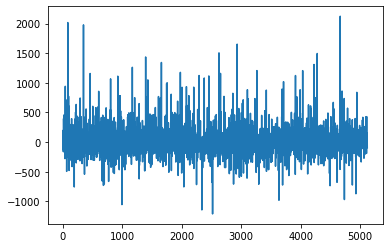

In [89]:
plt.plot(np.arange(0,len(ydiff),1),ydiff)

In [13]:
# def rfr_model(X, y):
# # Perform Grid-Search
#     gsc = GridSearchCV(
#         estimator=RandomForestRegressor(),
#         param_grid={
#             'max_depth': range(3,7),
#             'n_estimators': (10, 50, 100, 1000),
#         },
#         cv=5, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)
    
#     grid_result = gsc.fit(X, y)
#     best_params = grid_result.best_params_
    
#     rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],                               
#                                 random_state=False, verbose=False)
#     # Perform K-Fold CV
#     scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

#     return scores

In [67]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [70]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 57.0min finished
/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [90]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [91]:
# THIS TOOK A LONG TIME TO COMPILE #
# {'n_estimators': 1000,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'max_depth': 10,
#  'bootstrap': True}

In [92]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


In [93]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Model Performance
Average Error: 141.8708 degrees.
Accuracy = -inf%.


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [94]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_test, y_test)


Model Performance
Average Error: 119.4564 degrees.
Accuracy = -inf%.


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [95]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Improvement of nan%.


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


In [99]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 15],
    'max_features': [2, 3],
    'min_samples_leaf': [2,3],
    'min_samples_split': [10, 12],
    'n_estimators': [1000, 1200]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)


In [102]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, x_test, y_test)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  8.2min finished
/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Model Performance
Average Error: 123.4753 degrees.
Accuracy = -inf%.


/Users/mark/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


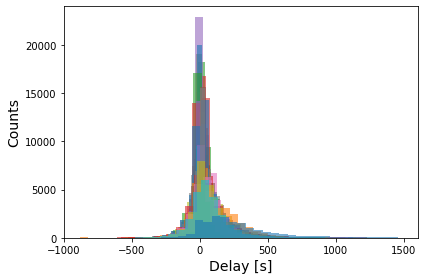

glb_max  2549.0  glb_min  -1308.0


In [96]:
# PLOT OF DELAY TIMES

# GET DATA
glb_max=0.0
glb_min=0.0

for station_num_id in range(len(MBTdelay_df)):  
    test_df=MBTdelay_df[station_num_id][2]
    loc_max=np.max(test_df['HEAD_GAP'])
    loc_min=np.min(test_df['HEAD_GAP'])
    if(loc_max>glb_max):
        glb_max=loc_max
    if(loc_min<glb_min):
        glb_min=loc_min
    plt.hist(test_df['HEAD_GAP'],bins=50,alpha=0.6)

plt.xlabel('Delay [s]',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.xlim([-1000,1600])
plt.tight_layout()
plt.savefig("PLOTS/hist_all_stat.pdf")
plt.show()
print("glb_max ",glb_max," glb_min ",glb_min)

In [109]:
loss_stats=[]

GAP_RES=[]

prod_regr = RandomForestRegressor(n_estimators=1000,
 min_samples_split=5,
 min_samples_leaf=2,
 max_features="sqrt",
 max_depth=10,
 bootstrap=True)

# GET DATA
for station_num_id in range(len(MBTdelay_df)):
    station_name=MBTdelay_df[station_num_id][0]
    station_id=MBTdelay_df[station_num_id][1]
    
    test_df=MBTdelay_df[station_num_id][2]

    test_df=MBTdelay_df[station_num_id][2]
    test_df['HEAD_GAP']=test_df['HEAD_GAP'].fillna(0)
    # ONE HOT ENCODE EVENT 1-yes 0-no
    test_df['event']=test_df['event'].apply(lambda x: ohe_event(x))

    gap_mode=stats.mode(test_df['HEAD_GAP'].values)
    gap_mean=np.mean(test_df['HEAD_GAP'])
    gap_mean_unc=np.std(test_df['HEAD_GAP'])/np.sqrt(len(test_df['HEAD_GAP']))
    
    GAP_RES.append([station_name,station_id,
                    gap_mode,
                    gap_mean,
                    gap_mean_unc
                    ])
    
    lr_df=test_df[np.isfinite(test_df['TEMP'])]

    all_x=np.transpose(np.array([ 
                                    lr_df['HOUR_BIN'],  
                                    lr_df['MONTH_BIN'],
                                    lr_df['DOW'],
                                    lr_df['event'],
                                    lr_df['PRECIP_PRO'],
                                    lr_df['PRECIP_INT'], 
                                    lr_df['PRECIP_ACC'], 
                                    lr_df['TEMP']],dtype=np.float32))

    all_y=np.transpose(np.array([lr_df['HEAD_GAP']],dtype=np.float32))
    all_y=np.transpose(all_y)[0]

    x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=42)
    

    # Train the model using the training sets
    prod_regr.fit(x_train, y_train)

    # Make predictions using the testing set
    y_pred = prod_regr.predict(x_test)

    # The mean squared error
    mse_loc=mean_squared_error(y_test,y_pred)
    print("Mean squared error: %.2f" % mse_loc)
    # Explained variance score: 1 is perfect prediction
    r2_loc=r2_score(y_test,y_pred)
    print('Variance score: %.2f' % r2_score(y_test,y_pred))
    
    loss_stats.append([mse_loc,r2_loc])
    pickle.dump(prod_regr, open('RF_MODEL/'+station_name+'_'+station_id+'.pk', 'wb'))
    
#     plt.hist(test_df['HEAD_GAP'],bins=50)

# plt.show()


Mean squared error: 4690.38
Variance score: 0.03
Mean squared error: 23916.85
Variance score: 0.12
Mean squared error: 4089.67
Variance score: 0.08
Mean squared error: 32194.94
Variance score: 0.07
Mean squared error: 19191.61
Variance score: 0.09
Mean squared error: 11545.31
Variance score: 0.07
Mean squared error: 9663.26
Variance score: 0.16
Mean squared error: 32945.83
Variance score: 0.04
Mean squared error: 18536.61
Variance score: 0.08
Mean squared error: 27572.06
Variance score: 0.04
Mean squared error: 32315.73
Variance score: 0.09
Mean squared error: 15680.82
Variance score: 0.14
Mean squared error: 29752.62
Variance score: 0.10
Mean squared error: 6284.34
Variance score: 0.22
Mean squared error: 5649.98
Variance score: 0.20
Mean squared error: 25963.18
Variance score: 0.31
Mean squared error: 742.69
Variance score: 0.08
Mean squared error: 3612.01
Variance score: 0.14
Mean squared error: 38380.75
Variance score: 0.04
Mean squared error: 21250.35
Variance score: 0.09
Mean squ

In [110]:
    
GAP_RES=np.array(GAP_RES) 
with open('MODELS/DH_RES.csv', mode='w') as dh_file:
    dh_file=csv.writer(dh_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dh_file.writerow(["station_name","station_id","MEAN_GAP","UNC_MEAN_GAP"])
    for line in range(len(GAP_RES)):
        dh_file.writerow([GAP_RES[line,0],GAP_RES[line,1],GAP_RES[line,2],GAP_RES[line,3]])

# print("OVERALL MEAN GAP=",np.mean(np.mean(GAP_RES[:,2].astype(float).round(2))),np.mean(np.mean(GAP_RES[:,3].astype(float))))
                                 

In [111]:

all_delays=[]
for i in range(len(MBTdelay_df[:,2])):
    all_delays.append(MBTdelay_df[:,2][i]['HEAD_GAP'].values)

all_delays=[round(val,0) for sublist in all_delays for val in sublist] 
stats.mode(all_delays)

ModeResult(mode=array([8.]), count=array([15014]))

No handles with labels found to put in legend.


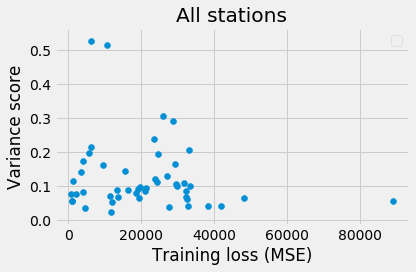

In [112]:
loss_stats=np.array(loss_stats)
plt.scatter(loss_stats[:,0],loss_stats[:,1])
plt.title("All stations")
plt.xlabel("Training loss (MSE)")
plt.ylabel("Variance score")
# xr=np.arange(0,250000)
# plt.plot(xr,xr,label="1:1",color="C1")
plt.legend()
plt.tight_layout()
plt.savefig("train_test_err.pdf")

No handles with labels found to put in legend.


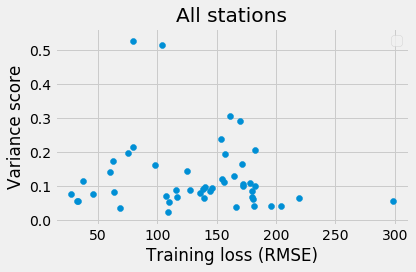

In [121]:
loss_stats=np.array(loss_stats)
plt.scatter(np.sqrt(loss_stats[:,0]),loss_stats[:,1])
plt.title("All stations")
plt.xlabel("Training loss (RMSE)")
plt.ylabel("Variance score")
# xr=np.arange(0,250000)
# plt.plot(xr,xr,label="1:1",color="C1")
plt.legend()
plt.tight_layout()
plt.savefig("train_test_err.pdf")

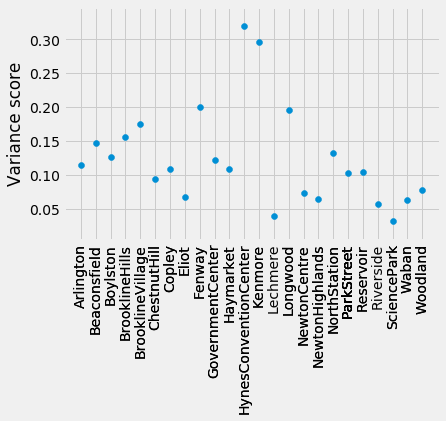

In [116]:
# plt.subplots(figsize=(5, 10))
plt.style.use('fivethirtyeight')

loss_stats=np.array(loss_stats)

all_dat=[ [MBTdelay_df[i][0],loss_stats[:,1][i]] for i in range(len(MBTdelay_df[:,2]))]
all_dat=np.array(all_dat)
results=[]
for x in np.unique(all_dat[:,0]):
    
    results.append([x,np.average(all_dat[np.where(all_dat[:,0]==x)][:,1].astype(float))])
    
results=np.array(results)

xnames=[MBTdelay_df[i][0] for i in range(len(MBTdelay_df[:,2]))]
plt.scatter(results[:,0],results[:,1].astype(float))
# plt.title("All stations")
# plt.xlabel("Training loss (MSE)")
plt.ylabel("Variance score")
# xr=np.arange(0,250000)
# plt.plot(xr,xr,label="1:1",color="C1")
plt.xticks(xnames, rotation='vertical')

# plt.legend()
# plt.tight_layout

plt.savefig("FIGS/RF_train_test_err.pdf")

In [122]:
def get_cv_score_rf_model(X, yin):
    LModel = RandomForestRegressor(n_estimators=1000,
     min_samples_split=5,
     min_samples_leaf=2,
     max_features="sqrt",
     max_depth=10,
     bootstrap=True)
    scaler = RobustScaler()
    pipe = Pipeline(steps=[('scaler', scaler), ('linear', LModel)])
    cv_results = cross_validate(pipe, X, yin, cv = 5, n_jobs = -1,
                                scoring = ('r2', 'neg_mean_absolute_error'),
                                verbose = 0)
    mae_mean_score = -cv_results['test_neg_mean_absolute_error'].mean()
    r2_mean_score = -cv_results['test_r2'].mean()
    regr = RandomForestRegressor(n_estimators=1000,
     min_samples_split=5,
     min_samples_leaf=2,
     max_features="sqrt",
     max_depth=10,
     bootstrap=True)
    pipe = Pipeline(steps=[('scaler', scaler), ('linear', regr)])
    pipe.fit(X, yin)

    return mae_mean_score, r2_mean_score, pipe

In [124]:
mae_mean_score_loc, r2_mean_score_loc, pipe_loc=get_cv_score_rf_model(x_train,y_train)

array([249.59656924, 340.78661084, 322.91119868, ..., 364.05589999,
       262.69468495, 275.41093543])

In [ ]:
loss_stats=[]

GAP_RES=[]

prod_regr = RandomForestRegressor(n_estimators=1000,
 min_samples_split=5,
 min_samples_leaf=2,
 max_features="sqrt",
 max_depth=10,
 bootstrap=True)

# GET DATA
for station_num_id in range(len(MBTdelay_df)):
    station_name=MBTdelay_df[station_num_id][0]
    station_id=MBTdelay_df[station_num_id][1]
    
    test_df=MBTdelay_df[station_num_id][2]

    test_df=MBTdelay_df[station_num_id][2]
    test_df['HEAD_GAP']=test_df['HEAD_GAP'].fillna(0)
    # ONE HOT ENCODE EVENT 1-yes 0-no
    test_df['event']=test_df['event'].apply(lambda x: ohe_event(x))

    gap_mode=stats.mode(test_df['HEAD_GAP'].values)
    gap_mean=np.mean(test_df['HEAD_GAP'])
    gap_mean_unc=np.std(test_df['HEAD_GAP'])/np.sqrt(len(test_df['HEAD_GAP']))
    
    GAP_RES.append([station_name,station_id,
                    gap_mode,
                    gap_mean,
                    gap_mean_unc
                    ])
    
    lr_df=test_df[np.isfinite(test_df['TEMP'])]

    all_x=np.transpose(np.array([ 
                                    lr_df['HOUR_BIN'],  
                                    lr_df['MONTH_BIN'],
                                    lr_df['DOW'],
                                    lr_df['event'],
                                    lr_df['PRECIP_PRO'],
                                    lr_df['PRECIP_INT'], 
                                    lr_df['PRECIP_ACC'], 
                                    lr_df['TEMP']],dtype=np.float32))

    all_y=np.transpose(np.array([lr_df['HEAD_GAP']],dtype=np.float32))
    all_y=np.transpose(all_y)[0]

    x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=42)
    
    # Train the model using the training sets
    mae_mean_score, r2_mean_score, pipe=get_cv_score_rf_model(x_train,y_train)
    
    # Make predictions using the testing set
    y_pred = prod_regr.predict(x_test)

    # The mean squared error
    mse_loc=mean_squared_error(y_test,y_pred)
    print("Mean squared error: %.2f" % mse_loc)
    # Explained variance score: 1 is perfect prediction
    r2_loc=r2_score(y_test,y_pred)
    print('Variance score: %.2f' % r2_score(y_test,y_pred))
    
    loss_stats.append([mse_loc,r2_loc])
    pickle.dump(prod_regr, open('RF_MODEL/'+station_name+'_'+station_id+'.pk', 'wb'))
    
#     plt.hist(test_df['HEAD_GAP'],bins=50)

# plt.show()
